<a href="https://colab.research.google.com/github/KiranmayiBandaru/SalesForcast-StatisticalModel/blob/main/SalesForcast-StatisticalModel/Sales_Time_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Pandas and Openpyxl if not already installed
!pip install pandas openpyxl

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving region3.xlsx to region3.xlsx


In [ ]:
import numpy as np
import pandas as pd
df = pd.read_excel('region1.xlsx')
df['time stamp'] = pd.to_datetime(df['time stamp'])
df.loc[df["demand"] < 0, "demand"] = 0
df.sort_values(by="time stamp",inplace=True)
df.set_index("time stamp", inplace=True)
# print(set1.to_string())
df.tail(10)
# print(set1.index)
# print(df.index.min())

,Item_id,demand
time stamp,,
2023-11-13,Item-1 - Region-1,0.000000
2023-11-20,Item-1 - Region-1,139.000000
2023-11-27,Item-1 - Region-1,117.000000
2023-12-06,Item-1 - Region-1,0.000000
2023-12-18,Item-1 - Region-1,0.000000
2023-12-25,Item-1 - Region-1,11.000000
2024-01-01,Item-1 - Region-1,45.093090
2024-01-15,Item-1 - Region-1,48.840680
2024-01-22,Item-1 - Region-1,45.873469


In [ ]:
#lets us assign the weeks to 0,that are accumulated due to 0 demand
# print(df.index.min())
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='W')
df = df.reindex(full_range.union(df.index))
df['demand']=df['demand'].fillna(0)

df.tail(10)

,Item_id,demand
2024-06-02,NaN,0.000000
2024-06-09,NaN,0.000000
2024-06-16,NaN,0.000000
2024-06-23,NaN,0.000000
2024-06-30,NaN,0.000000
2024-07-07,NaN,0.000000
2024-07-14,NaN,0.000000
2024-07-21,NaN,0.000000
2024-07-28,NaN,0.000000
2024-08-01,Item-1 - Region-1,38.768734


In [ ]:
#finding mean and variance to find the stationarity of the data
df['rollMean'] = df.demand.rolling(window=12).mean()
df['rollStd'] = df.demand.rolling(window=12).std()

<Axes: >

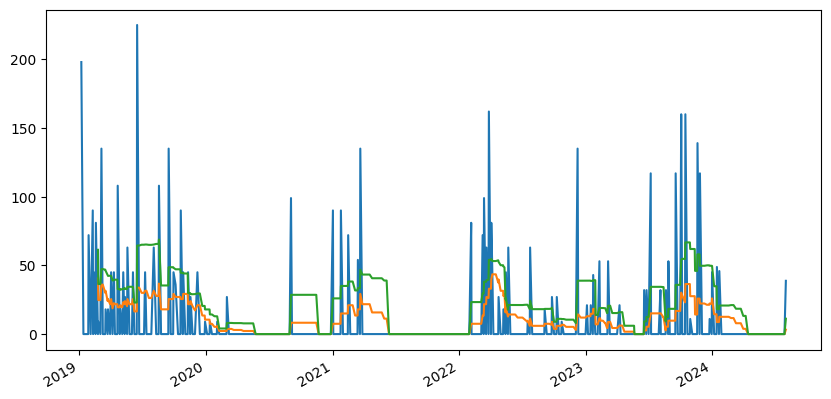

In [ ]:
#plotting the mean and variance along the demand
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
df['demand'].plot()
df['rollMean'].plot()
df['rollStd'].plot()
###from the observation it is clear that mean and variance are not stationary


#using seaborn
# sns.lineplot(data=set1,x=set1.index,y=set1.demand)
#sns.lineplot(data=set1,x=set1.index,y=set1.rollMean)
#sns.lineplot(data=set1,x=set1.index,y=set1.rollStd)

Step 2: Visualization


In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
adfTest=adfuller(df['demand'],autolag='AIC')
adfTest

(-6.804730170391508,
 2.1914189794511134e-09,
 4,
 393,
 {'1%': -3.447099431978147,
  '5%': -2.8689225261604263,
  '10%': -2.57070269105012},
 3670.8641990117558)

In [ ]:
stats=pd.Series(adfTest[0:4],index=['ADF statistics','p-value','#lags used','No. of observations used'])
stats

,0
ADF statistics,-6.804730e+00
p-value,2.191419e-09
#lags used,4.000000e+00
No. of observations used,3.930000e+02


In [ ]:
#the data must be stationary
#we conduct dicky fuller test to see if it is stationary or non stationary
result = adfuller(df["demand"])
def adfuller_test(demands):
  values=adfuller(demands)
  labels = ['ADF statistic','p-value','#lags used','No. of observations used']
  for value,label in zip(values,labels):
    print(label+":"+str(value) )
  if values[1] < 0.05:
    print("Stationary data.")
  else:
   print("Non-Stationary data.")
adfuller_test(df['demand'])

ADF statistic:-6.804730170391508
p-value:2.1914189794511134e-09
#lags used:4
No. of observations used:393
Stationary data.


Check with ACF/PACF: To confirm whether seasonality exists

In [ ]:
df['seasonal difference'] = df['demand']-df['demand'].shift(4)
df.tail()
# print(df.index.freq)  # This shows the frequency of your time series (e.g., 'W' for weekly)


,Item_id,demand,rollMean,rollStd,seasonal difference
2024-07-07,NaN,0.000000,0.000000,0.00000,0.000000
2024-07-14,NaN,0.000000,0.000000,0.00000,0.000000
2024-07-21,NaN,0.000000,0.000000,0.00000,0.000000
2024-07-28,NaN,0.000000,0.000000,0.00000,0.000000
2024-08-01,Item-1 - Region-1,38.768734,3.230728,11.19157,38.768734


In [ ]:

# set1['seasonal difference'].head(10)
adfuller_test(df['seasonal difference'].dropna())


ADF statistic:-6.61553683431187
p-value:6.221005842901826e-09
#lags used:15
No. of observations used:378
Stationary data.


<Axes: >

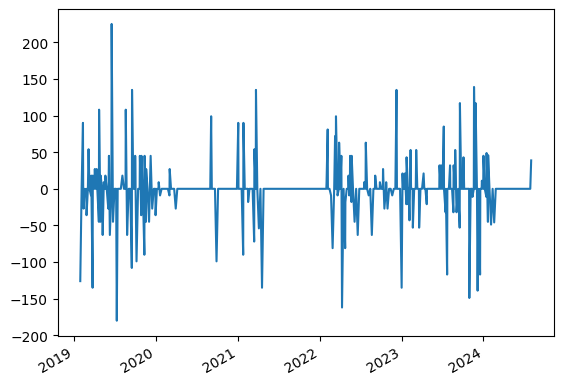

In [ ]:
df['seasonal difference'].plot()


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


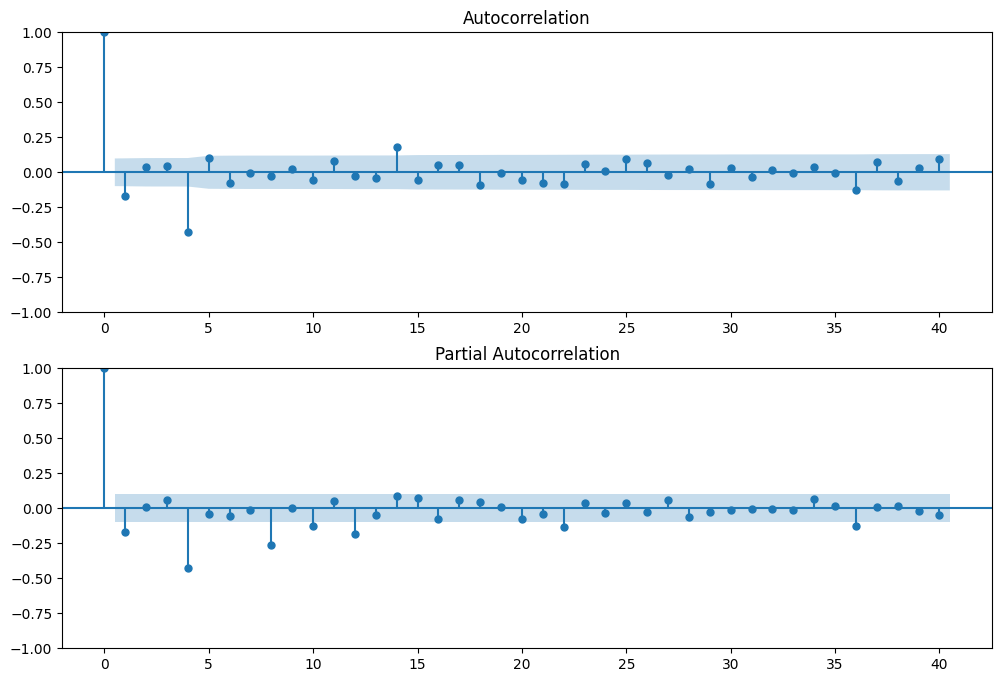

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['seasonal difference'].iloc[4:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['seasonal difference'].iloc[4:],lags=40,ax=ax2)

In [ ]:
#p=0,d=0,q=2
import statsmodels.api as sm
df.index = pd.to_datetime(df.index)  # Ensure the index is datetime-based
df = df.asfreq('W')  # Assign weekly frequency; adjust to 'D', 'M', etc., if needed
model = sm.tsa.statespace.SARIMAX(df['demand'],order=(0,0,1),seasonal_order=(0,0,1,4))
results = model.fit()


# print(results.summary())


2024-07-28 00:00:00


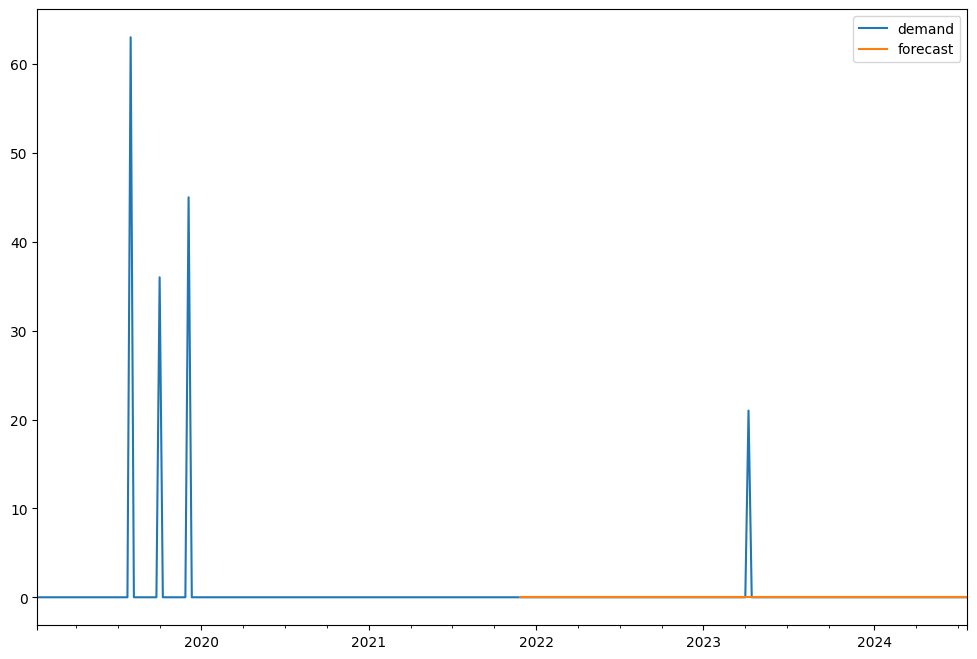

In [ ]:
df['forecast']=results.predict(start=150,end=290,dynamic=True)
df[['demand','forecast']].plot(figsize=(12,8))
print(df.index[-1])

In [ ]:
from pandas.tseries.offsets import DateOffset
future_dates = [df.index[-1] + DateOffset(weeks=x) for x in range(1, 4)]
# future_dates = [date for date in future_dates if date not in df.index]
# print(future_dates)
future_dataset_df=pd.DataFrame(index=future_dates,columns=df.columns)
future_dataset_df['demand']=0
future_dataset_df['Item_id']='item-1 - Region-1'

future_dataset_df.tail()

,Item_id,demand,rollMean,rollStd,seasonal difference,forecast
2024-08-04,item-1 - Region-1,0,NaN,NaN,NaN,NaN
2024-08-11,item-1 - Region-1,0,NaN,NaN,NaN,NaN
2024-08-18,item-1 - Region-1,0,NaN,NaN,NaN,NaN


290
3


,Item_id,demand,rollMean,rollStd,seasonal difference,forecast
2024-06-16,NaN,0.0,0.0,0.0,0.0,NaN
2024-06-23,NaN,0.0,0.0,0.0,0.0,NaN
2024-06-30,NaN,0.0,0.0,0.0,0.0,NaN
2024-07-07,NaN,0.0,0.0,0.0,0.0,NaN
2024-07-14,NaN,0.0,0.0,0.0,0.0,NaN
2024-07-21,NaN,0.0,0.0,0.0,0.0,NaN
2024-07-28,NaN,0.0,0.0,0.0,0.0,NaN
2024-08-04,item-1 - Region-1,0.0,NaN,NaN,NaN,-3.364881e-100
2024-08-11,item-1 - Region-1,0.0,NaN,NaN,NaN,1.098011e-109
2024-08-18,item-1 - Region-1,0.0,NaN,NaN,NaN,7.989104e-115


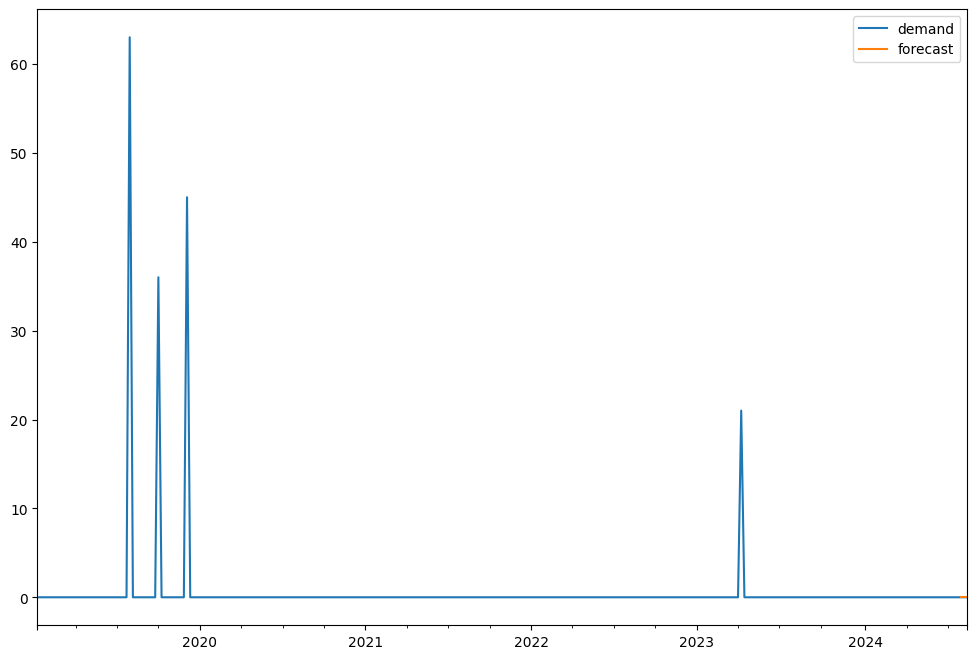

In [ ]:

import pandas as pd
future_dataset_df = future_dataset_df.dropna(how='all', axis=1)

future_df = pd.concat([df, future_dataset_df])
start = len(df)  # Start prediction from the first row of future data
end = start + len(future_dataset_df) - 1
print(len(df))
print(len(future_dataset_df))
future_df['forecast'] = results.predict(start=start, end=end, dynamic=True)
future_df[['demand','forecast']].plot(figsize=(12,8))
future_df.index = pd.to_datetime(future_df.index)  # Ensure index is datetime-based
future_df.tail(10)

In [ ]:
predicted_next_3_weeks = future_df['forecast'][-3:]
print("Predicted demand for the next 3 weeks:")
print(predicted_next_3_weeks)

Predicted demand for the next 3 weeks:
2024-08-04   -3.364881e-100
2024-08-11    1.098011e-109
2024-08-18    7.989104e-115
Name: forecast, dtype: float64


In [ ]:
print(future_df.tail(3))


                      Item_id  demand  rollMean  rollStd  seasonal difference  \
2024-08-04  item-1 - Region-1     0.0       NaN      NaN                  NaN   
2024-08-11  item-1 - Region-1     0.0       NaN      NaN                  NaN   
2024-08-18  item-1 - Region-1     0.0       NaN      NaN                  NaN   

                 forecast  
2024-08-04 -3.364881e-100  
2024-08-11  1.098011e-109  
2024-08-18  7.989104e-115  
